# Модели TensorFlow

In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
import IPython
import IPython.display
import matplotlib as mpl
import tensorflow as tf
from keras import backend as K

In [182]:
energo = pd.read_csv('result.csv', index_col='Местное время в Красноярске')

## Описание данных

In [183]:
df = energo[['Генерация, МВт*ч\\', 'Потребление, МВт*ч', 'T', 'Po', 'U', 'Ff', 'VV']]

column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)
num_features = df.shape[1]
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

#### Параметры
+ T - Температура
+ Po - Атмосферное давление
+ U - Обносительная влажность
+ Ff - скорость ветра
+ VV - Горизонтальная дальность видимости

In [184]:
df.head(1)

,"Генерация, МВт*ч\","Потребление, МВт*ч",T,Po,U,Ff,VV
Местное время в Красноярске,,,,,,,
01.01.2019 04:00,24804,25605,-23.6,751.0,84.0,1.0,4.0


In [185]:
df[:1412].describe()  # Зима

,"Генерация, МВт*ч\","Потребление, МВт*ч",T,Po,U,Ff,VV
count,1412.000000,1412.000000,1412.000000,1412.000000,1412.000000,1412.000000,1412.000000
mean,26999.070822,27445.497875,-13.268768,745.497875,69.438385,2.146601,13.560907
std,1572.602506,1495.318775,11.211214,7.219991,15.704700,1.917626,17.132654
min,22672.000000,23852.000000,-39.900000,730.000000,32.000000,0.000000,2.000000
25%,25861.500000,26362.250000,-21.500000,740.000000,57.000000,1.000000,4.000000
50%,27013.500000,27469.000000,-10.700000,747.000000,75.000000,2.000000,4.000000
75%,28103.000000,28529.000000,-3.800000,751.000000,80.000000,3.000000,20.000000
max,30672.000000,31015.000000,6.000000,761.000000,100.000000,8.000000,50.000000


In [186]:
df[1412:3620].describe()  # Весна

,"Генерация, МВт*ч\","Потребление, МВт*ч",T,Po,U,Ff,VV
count,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000
mean,23349.438406,23768.365036,4.491214,739.304801,57.769022,2.002264,28.921196
std,1626.823046,1436.129183,7.002228,5.879698,18.540544,1.367463,21.224140
min,19022.000000,19684.000000,-9.200000,719.000000,13.000000,0.000000,1.000000
25%,22213.250000,22766.000000,-0.800000,735.000000,44.000000,1.000000,4.000000
50%,23286.500000,23781.500000,3.800000,740.000000,55.000000,2.000000,20.000000
75%,24521.500000,24866.750000,8.600000,744.000000,71.000000,3.000000,50.000000
max,26868.000000,26986.000000,27.400000,751.000000,98.000000,7.000000,50.000000


In [187]:
df[3620:5828].describe()  # Лето

,"Генерация, МВт*ч\","Потребление, МВт*ч",T,Po,U,Ff,VV
count,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000
mean,20648.283514,21041.851449,18.396649,733.326540,69.915761,1.327899,30.008288
std,1078.595966,1105.125153,5.151885,3.047693,18.223159,0.984382,20.646400
min,17531.000000,18750.000000,0.500000,727.000000,28.000000,0.000000,0.100000
25%,19681.750000,19938.500000,14.800000,731.000000,55.000000,1.000000,4.000000
50%,21039.500000,21580.500000,18.200000,733.000000,72.000000,1.000000,20.000000
75%,21527.500000,21931.000000,21.800000,735.000000,85.000000,2.000000,50.000000
max,22487.000000,22996.000000,33.000000,743.000000,99.000000,5.000000,50.000000


In [188]:
df[5828:].describe()  # Осень

,"Генерация, МВт*ч\","Потребление, МВт*ч",T,Po,U,Ff,VV
count,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000
mean,22730.487202,22699.218888,9.053310,739.442189,68.109444,1.827008,25.634157
std,1176.909815,1419.617748,6.040805,5.247199,19.716328,1.331891,21.524395
min,19122.000000,19189.000000,-8.300000,726.000000,24.000000,0.000000,0.500000
25%,21920.000000,21786.000000,4.800000,736.000000,53.000000,1.000000,4.000000
50%,22826.000000,22803.000000,9.300000,739.000000,68.000000,2.000000,20.000000
75%,23543.000000,23804.000000,13.300000,743.000000,86.000000,3.000000,50.000000
max,25756.000000,25824.000000,26.300000,751.000000,100.000000,6.000000,50.000000


## Почасовой прогноз

In [189]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [190]:
len(train_df), len(val_df), len(test_df)

(4872, 1392, 697)

In [191]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def plot(self, model=None, plot_col='Потребление, МВт*ч', max_subplots=3, units='h'):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col}')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', color='orange', marker='v', zorder=-10, ms=3)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.plot(self.label_indices, labels[n, :, label_col_index],
                label='Labels', color='green', marker='.', ms=5)
            if model is not None:
                predictions = model(inputs)
                plt.plot(self.label_indices, predictions[n, :, label_col_index],
                  marker='s', label='Predictions', color='red', ms=3)

            if n == 0:
                plt.legend()

        plt.xlabel(f'Time [{units}]')
        
    def get(self, model, plot_col='Потребление, МВт*ч'):
        inputs, labels = self.example
        plot_col_index = self.column_indices[plot_col]
        max_n = min(3, len(inputs))
        
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index
        return model(inputs)[max_n-1, :, label_col_index]
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

        ds = ds.map(self.split_window)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

In [192]:
OUT_STEPS = 24*7
multi_window = WindowGenerator(input_width=24*7*3,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

# multi_window.plot()
# multi_window

In [193]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [194]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError(), coeff_determination])
                      # metrics=[coeff_determination])

multi_val_performance = {}
multi_performance = {}

# multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
# multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
# multi_window.plot(last_baseline)

#### Linear

In [195]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(), coeff_determination])
                # metrics=[coeff_determination])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

23/23 [==============================] - 0s 2ms/step - loss: 0.5089 - mean_absolute_error: 0.5367 - coeff_determination: 0.3897


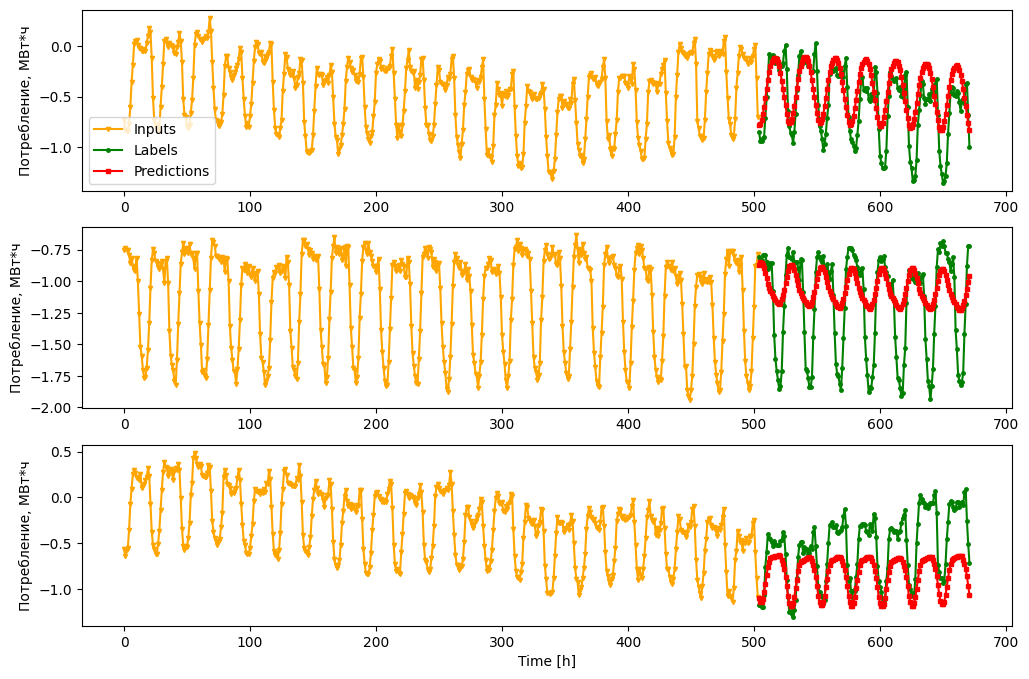

In [196]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

In [197]:
print(
    f"Metrics: {multi_linear_model.metrics_names}\n"
    f"Values: {multi_performance['Linear']}\n"
)

Metrics: ['loss', 'mean_absolute_error', 'coeff_determination']
Values: [0.594485342502594, 0.5888158679008484, 0.18739408254623413]



#### Dense

23/23 [==============================] - 0s 4ms/step - loss: 0.4591 - mean_absolute_error: 0.5161 - coeff_determination: 0.4483


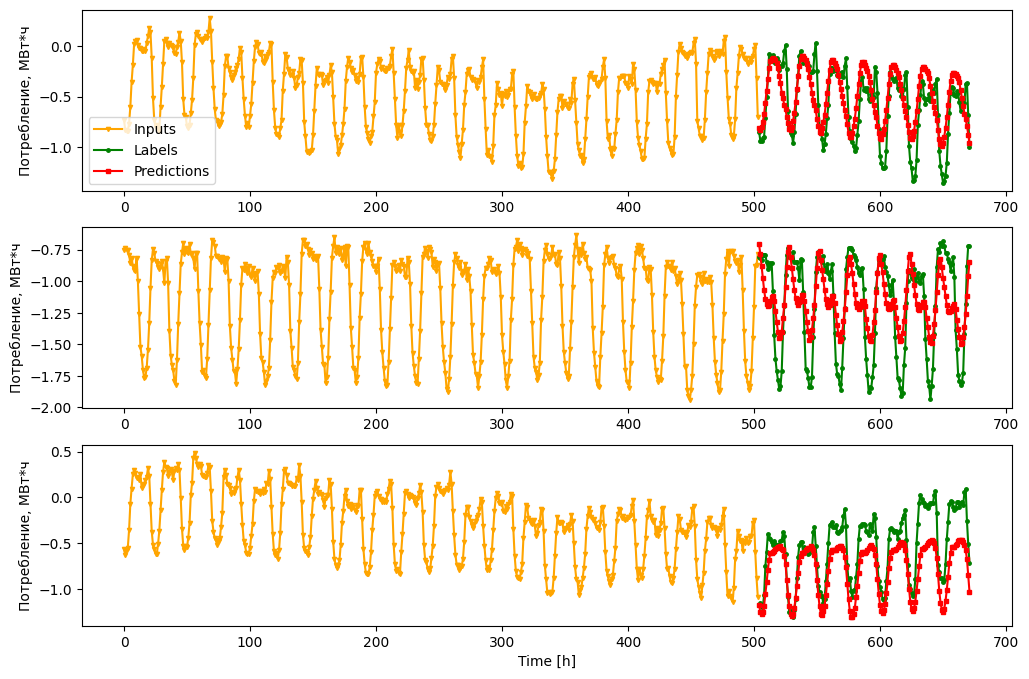

In [198]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

23/23 [==============================] - 0s 3ms/step - loss: 0.4015 - mean_absolute_error: 0.4738 - coeff_determination: 0.5186


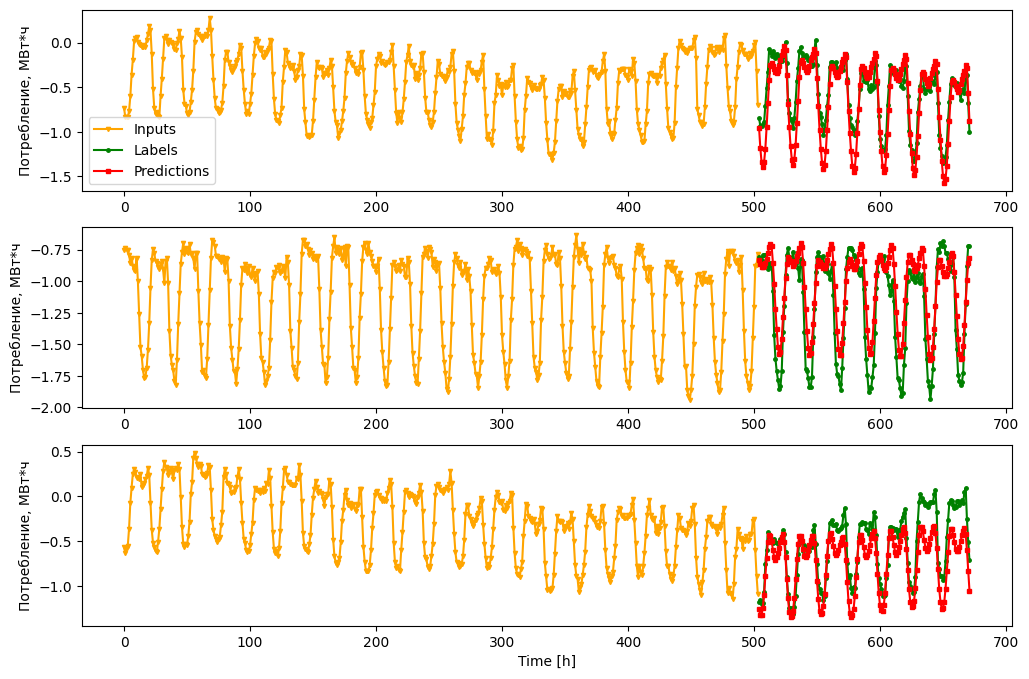

In [199]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

23/23 [==============================] - 1s 41ms/step - loss: 0.4072 - mean_absolute_error: 0.4961 - coeff_determination: 0.5106


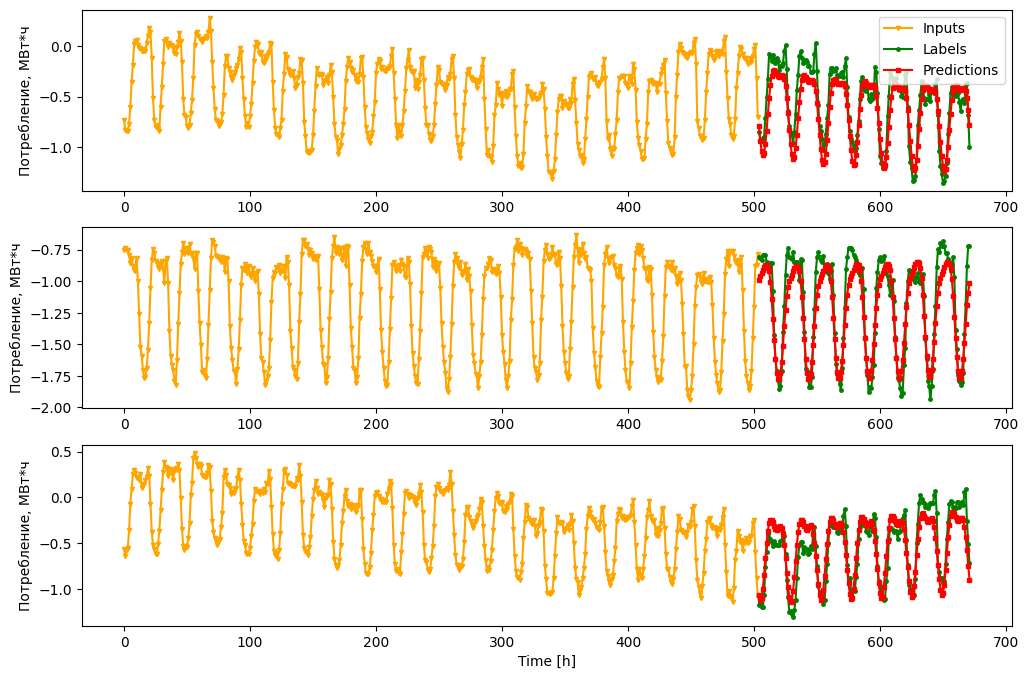

In [200]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

#### Сравнение

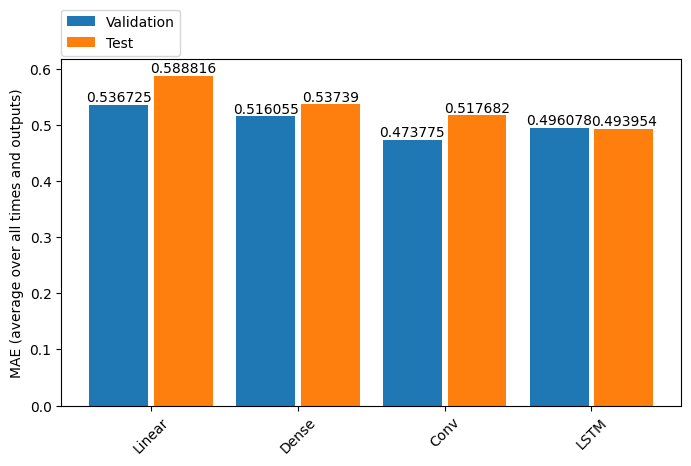

In [201]:
x = np.arange(len(multi_performance))
width = 0.4

metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.figure(figsize=(8, 4.5))
bar1 = plt.bar(x - 0.22, val_mae, width, label='Validation')
bar2 = plt.bar(x + 0.22, test_mae, width, label='Test')
plt.bar_label(bar1)
plt.bar_label(bar2)
plt.xticks(ticks=x, labels=multi_performance.keys(), rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend(loc=(0, 1.01))

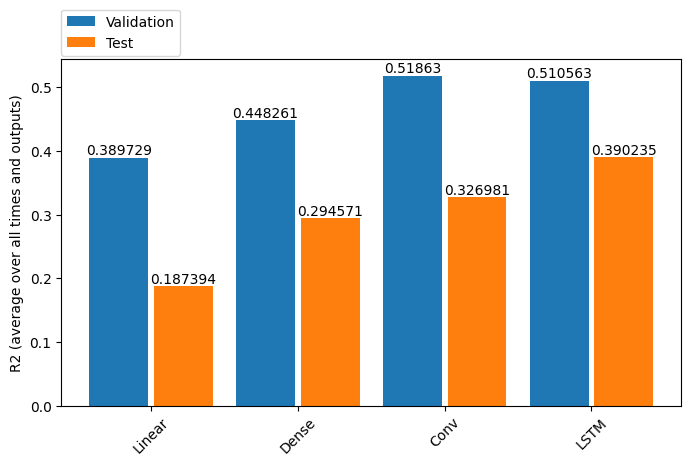

In [202]:
x = np.arange(len(multi_performance))
width = 0.4

metric_index = multi_lstm_model.metrics_names.index('coeff_determination')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.figure(figsize=(8, 4.5))
bar1 = plt.bar(x - 0.22, val_mae, width, label='Validation')
bar2 = plt.bar(x + 0.22, test_mae, width, label='Test')
plt.bar_label(bar1)
plt.bar_label(bar2)
plt.xticks(ticks=x, labels=multi_performance.keys(), rotation=45)
plt.ylabel(f'R2 (average over all times and outputs)')
_ = plt.legend(loc=(0, 1.01))

## Посуточный прогноз

In [395]:
labels = ['Генерация, МВт*ч\\', 'Потребление, МВт*ч', 'T', 'Po', 'U', 'Ff', 'VV']

In [396]:
days = len(energo['Потребление, МВт*ч'])
hours = days // 24

In [397]:
d = {i: [j.mean() for j in np.array(energo[i])[:24*hours].reshape((hours, 24))] for i in labels}

In [398]:
df = pd.DataFrame(d)

In [399]:
column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)
num_features = df.shape[1]
train_df = df[0:int(n*0.5)]
val_df = df[int(n*0.5):int(n*0.8)]
test_df = df[int(n*0.8):]

In [400]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [401]:
len(train_df), len(val_df), len(test_df)

(145, 87, 58)

In [402]:
OUT_STEPS = 20
multi_window = WindowGenerator(input_width=30,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

# multi_window.plot()
# multi_window

In [403]:
last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError(), coeff_determination])
                      # metrics=[coeff_determination])

multi_val_performance = {}
multi_performance = {}

# multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
# multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
# multi_window.plot(last_baseline)

#### Linear

In [404]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError(), coeff_determination])
                  # metrics=[coeff_determination])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

42/42 [==============================] - 0s 2ms/step - loss: 0.3907 - mean_absolute_error: 0.4556 - coeff_determination: 0.5700


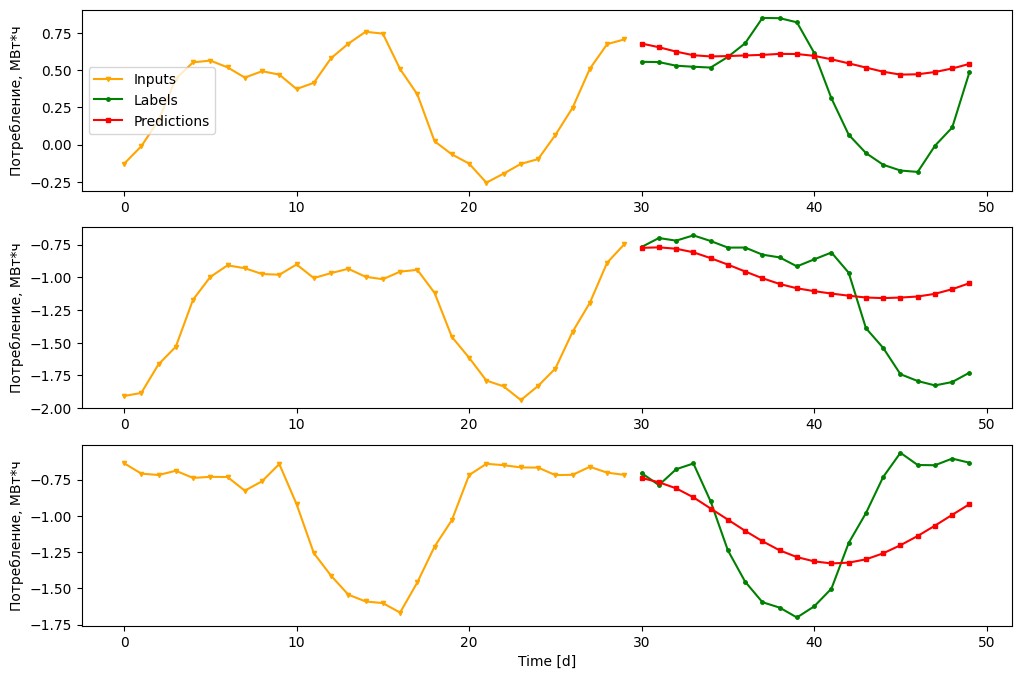

In [405]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model, units='d')

#### Dense

42/42 [==============================] - 0s 2ms/step - loss: 0.3504 - mean_absolute_error: 0.4348 - coeff_determination: 0.6146


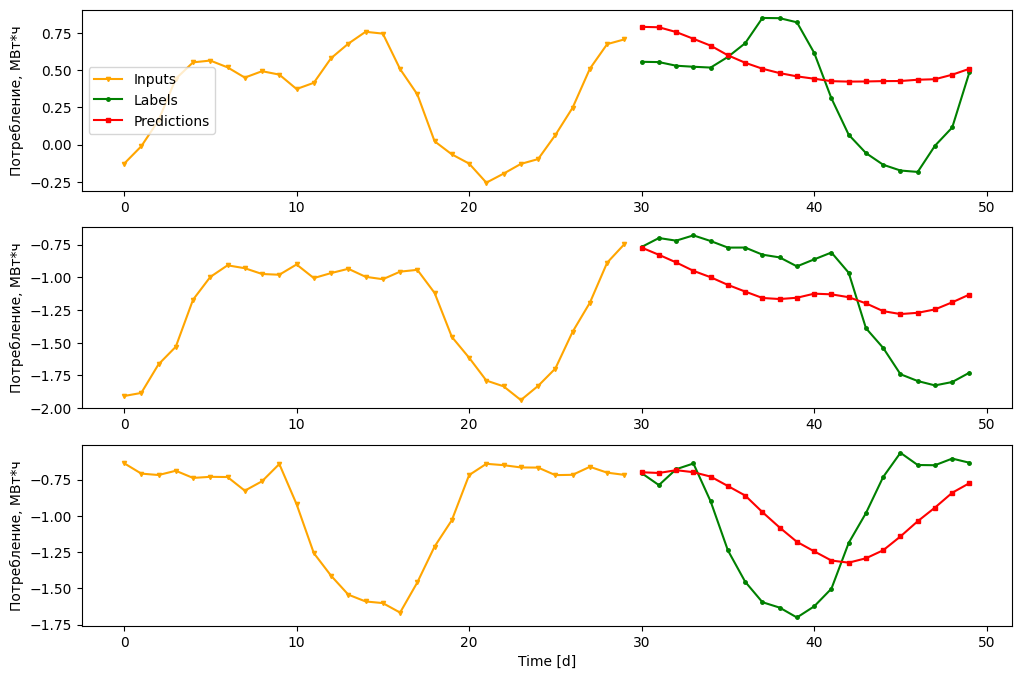

In [406]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model, units='d')

#### CNN

42/42 [==============================] - 0s 2ms/step - loss: 0.3243 - mean_absolute_error: 0.4094 - coeff_determination: 0.6431


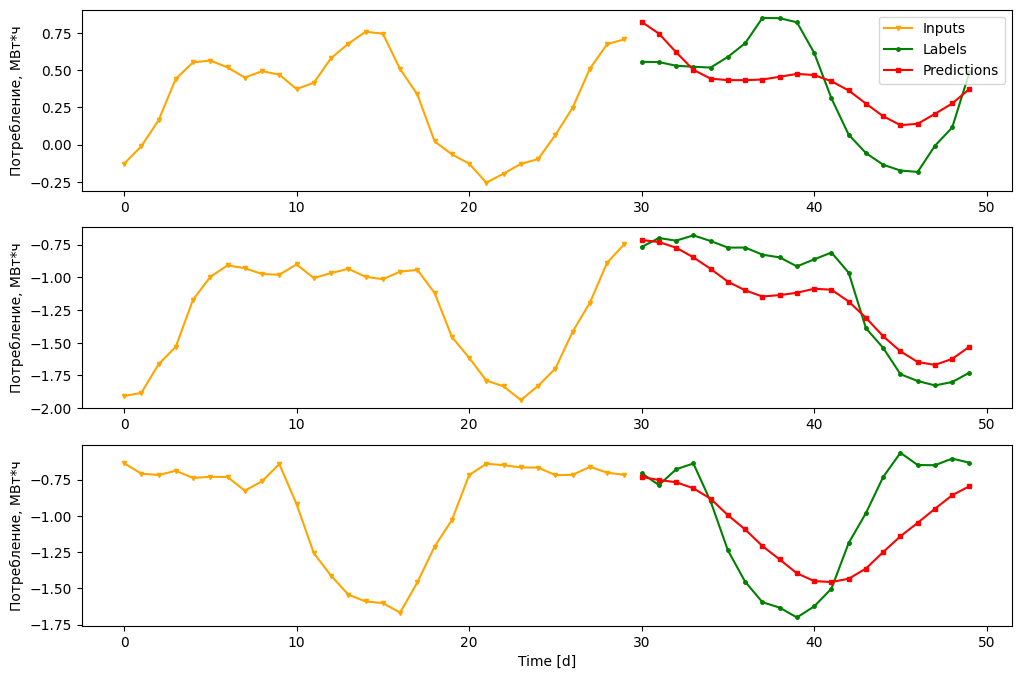

In [407]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model, units='d')

#### RNN

42/42 [==============================] - 0s 4ms/step - loss: 0.2771 - mean_absolute_error: 0.3860 - coeff_determination: 0.6947


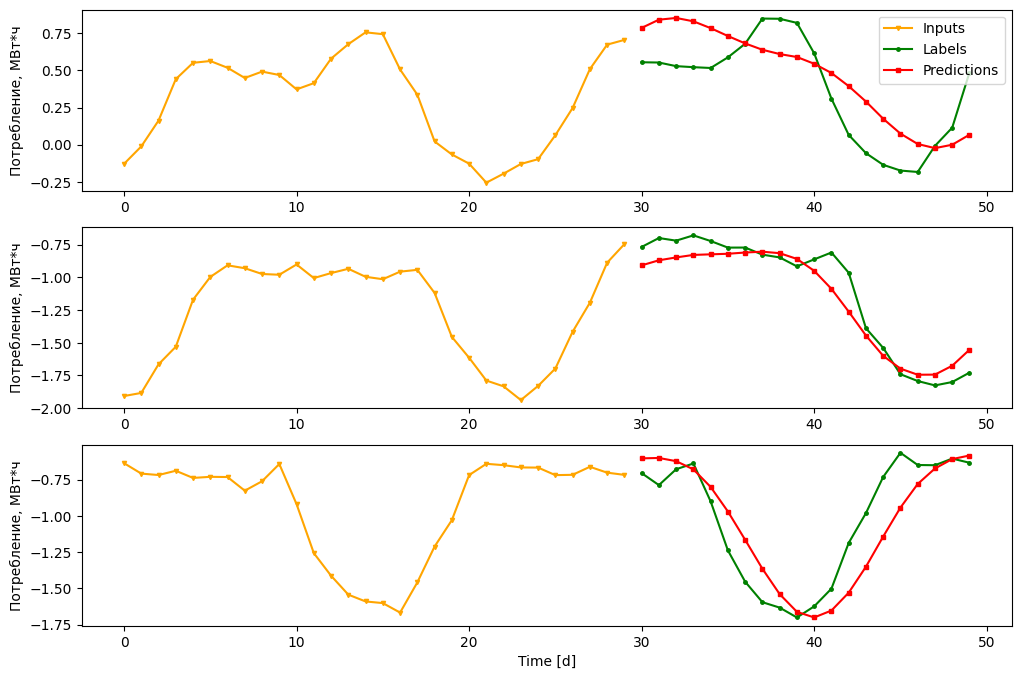

In [408]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model, units='d')

#### Сравнение

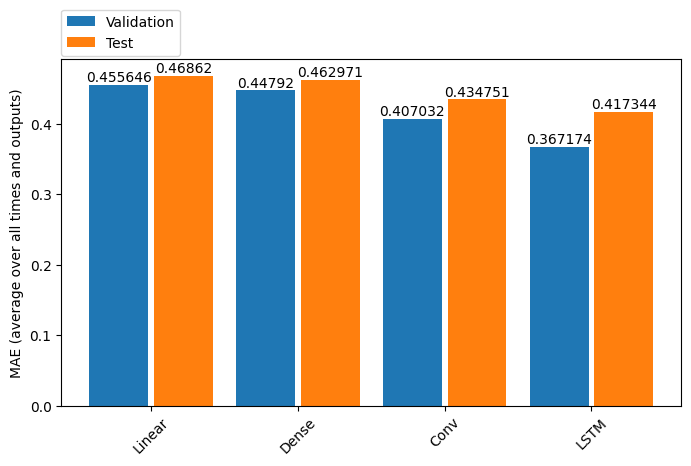

In [393]:
x = np.arange(len(multi_performance))
width = 0.4

metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.figure(figsize=(8, 4.5))
bar1 = plt.bar(x - 0.22, val_mae, width, label='Validation')
bar2 = plt.bar(x + 0.22, test_mae, width, label='Test')
plt.bar_label(bar1)
plt.bar_label(bar2)
plt.xticks(ticks=x, labels=multi_performance.keys(), rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
plt.legend(loc=(0, 1.01))
plt.show()

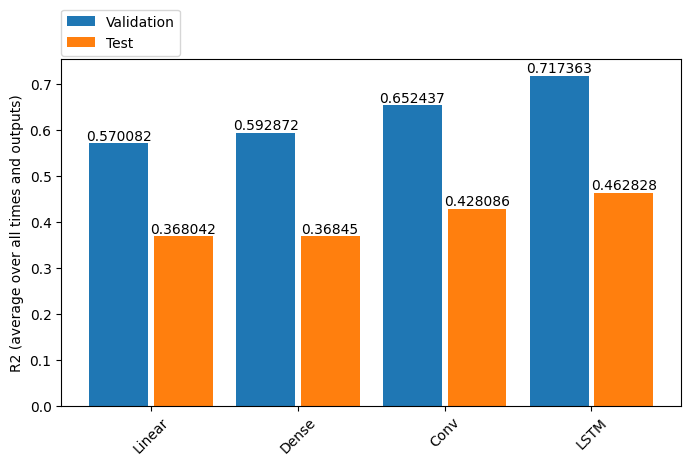

In [394]:
x = np.arange(len(multi_performance))
width = 0.4

metric_index = multi_lstm_model.metrics_names.index('coeff_determination')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.figure(figsize=(8, 4.5))
bar1 = plt.bar(x - 0.22, val_mae, width, label='Validation')
bar2 = plt.bar(x + 0.22, test_mae, width, label='Test')
plt.bar_label(bar1)
plt.bar_label(bar2)
plt.xticks(ticks=x, labels=multi_performance.keys(), rotation=45)
plt.ylabel(f'R2 (average over all times and outputs)')
plt.legend(loc=(0, 1.01))
plt.show()